In [70]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import os
import ast
import numpy as np
import string
from nltk.corpus import stopwords
from collections import Counter


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score

from textblob import TextBlob

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('float_format', '{:f}'.format)

#### Датасет

Был найден мультимодалный датасет с текстовыми отзывами и изображениями, приложенными к некоторым отзывам. Связка данных заключается в сочетании текстовой информации с соответствующими изображениями. 

In [40]:
data = pd.read_csv('/Users/kirillanosov/Downloads/reviews_data (2).csv',sep =';')

data.head()

,name,location,Date,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...


### Предварительная обработка данных

Текст

In [49]:
# убираем строки без отзывов
data = data.query('Review !="No Review Text"')

# приводим текстовые данные в нужный вид
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

data['Cleaned_Review'] = data['Review'].apply(clean_text)


/var/folders/bl/1vdqdmkn7cn_t9d3tk6b0pdw0000gn/T/ipykernel_23167/386460133.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cleaned_Review'] = data['Review'].apply(clean_text)


#### Изображения

In [75]:

# Функция для извлечения URL из колонки
def extract_urls(row):
    try:
        urls = ast.literal_eval(row)
        urls = [url for url in urls if url.startswith('http')]
        return urls
    except:
        return []

data['extracted_urls'] = data['Image_Links'].apply(extract_urls)

# Функция для скачивания и сохранения изображения
def download_image(url, save_path):
    response = requests.get(url)
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
        image.save(save_path)

# Путь для сохранения изображений
image_folder = 'path_to_save'  
os.makedirs(image_folder, exist_ok=True)

# Скачивание и сохранение изображений
for index, row in data.iterrows():
    for i, url in enumerate(row['extracted_urls']):
        try:
            file_path = os.path.join(image_folder, f'image_{index}_{i}.jpg')
            download_image(url, file_path)
            print(f'Изображение сохранено: {file_path}')
        except Exception as e:
            print(f'Не удалось скачать изображение: {url}. Ошибка: {e}')

# Добавление пути сохраненных изображений к данным
def add_image_paths(row):
    image_paths = []
    for i, _ in enumerate(row['extracted_urls']):
        image_path = os.path.join(image_folder, f'image_{row.name}_{i}.jpg')
        if os.path.exists(image_path):
            image_paths.append(image_path)
    return image_paths

data['image_paths'] = data.apply(add_image_paths, axis=1)




/var/folders/bl/1vdqdmkn7cn_t9d3tk6b0pdw0000gn/T/ipykernel_23167/4081345460.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['extracted_urls'] = data['Image_Links'].apply(extract_urls)


Изображение сохранено: path_to_save/image_2_0.jpg
Изображение сохранено: path_to_save/image_4_0.jpg
Изображение сохранено: path_to_save/image_4_1.jpg
Изображение сохранено: path_to_save/image_10_0.jpg
Изображение сохранено: path_to_save/image_18_0.jpg
Изображение сохранено: path_to_save/image_18_1.jpg
Изображение сохранено: path_to_save/image_20_0.jpg
Изображение сохранено: path_to_save/image_23_0.jpg
Изображение сохранено: path_to_save/image_28_0.jpg
Изображение сохранено: path_to_save/image_32_0.jpg
Изображение сохранено: path_to_save/image_33_0.jpg
Изображение сохранено: path_to_save/image_43_0.jpg
Изображение сохранено: path_to_save/image_67_0.jpg
Изображение сохранено: path_to_save/image_70_0.jpg
Изображение сохранено: path_to_save/image_81_0.jpg
Изображение сохранено: path_to_save/image_81_1.jpg
Изображение сохранено: path_to_save/image_94_0.jpg
Изображение сохранено: path_to_save/image_98_0.jpg
Изображение сохранено: path_to_save/image_109_0.jpg
Изображение сохранено: path_to_sa

/var/folders/bl/1vdqdmkn7cn_t9d3tk6b0pdw0000gn/T/ipykernel_23167/4081345460.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['image_paths'] = data.apply(add_image_paths, axis=1)


In [58]:
# изменяем размер изображения
def resize_image(image_path, size=(128, 128)):
    try:
        with Image.open(image_path) as img:
            img = img.resize(size)
            img.save(image_path)
    except Exception as e:
        print(f"Ошибка при изменении размера изображения: {e}")


for paths in data['image_paths']:
    for path in paths:
        resize_image(path)

Вы можете использовать полученные мультимодальные данные для разработки моделей сентимент-анализа, визуализации результатов, изучения влияния изображений на оценку отзывов и других задач.



### Разметка

In [51]:
# Функция для определения сентимента текста
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return "Позитивный"
    elif analysis.sentiment.polarity < 0:
        return "Отрицательный"
    else:
        return "Нейтральный"


data['Sentiment_Text'] = data['Review'].apply(get_sentiment)


/var/folders/bl/1vdqdmkn7cn_t9d3tk6b0pdw0000gn/T/ipykernel_23167/169671644.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sentiment_Text'] = data['Review'].apply(get_sentiment)


In [67]:
def sent_img(row):
    if row['image_paths']:  
        return row['Sentiment_Text']
    else:
        return 'No image'

# Применяем функцию к DataFrame
data['sent_img'] = data.apply(sent_img, axis=1)


/var/folders/bl/1vdqdmkn7cn_t9d3tk6b0pdw0000gn/T/ipykernel_23167/2744107119.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sent_img'] = data.apply(sent_img, axis=1)


### Результаты

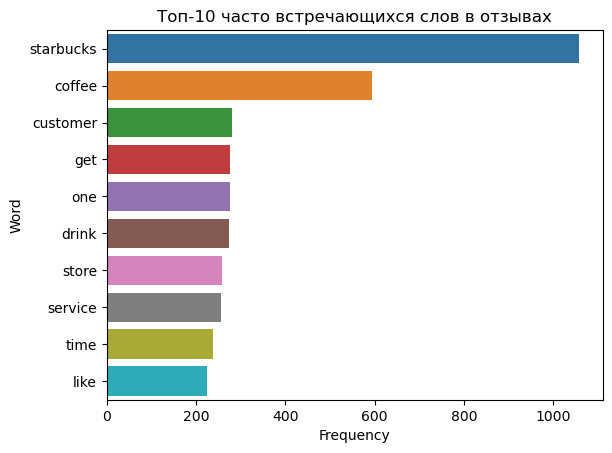

In [50]:
words = Counter(" ".join(data["Cleaned_Review"]).split()).most_common(10)
words_df = pd.DataFrame(words, columns=['Word', 'Frequency'])

sns.barplot(x='Frequency', y='Word', data=words_df)
plt.title('Топ-10 часто встречающихся слов в отзывах')
plt.show()


In [76]:
#сентименты изображений
data['sent_img'].value_counts()

sent_img
No image         767
Позитивный        23
Отрицательный     22
Нейтральный        1
Name: count, dtype: int64

In [74]:
#сентименты текстовых ревью
data['Sentiment_Text'].value_counts()

Sentiment_Text
Позитивный       442
Отрицательный    348
Нейтральный       23
Name: count, dtype: int64

### Кейсы использования

Эти данные могут быть использованы для разработки моделей машинного обучения, направленных на сентимент-анализ, а также для изучения взаимосвязи между визуальной и текстовой информацией в отзывах.


